In [40]:
# ============================================================
# 8_Final_Modeling.ipynb – Final Performance (with QWK)
# Modeling on fully engineered data + final comparison
# ============================================================

import os
import gc
import json
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    cohen_kappa_score,
    accuracy_score,
    f1_score,
    confusion_matrix
)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

RANDOM_STATE = 42
N_SPLITS = 5
DATA_VERSION = "final"  # used in filenames
OUTPUT_DIR = Path("./oof_predictions")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print("Config OK")


Config OK


In [41]:
# ============================================================
# Target column detection (same as in raw notebook)
# ============================================================

def infer_target_column(df, candidates=None, verbose=True):
    if candidates is None:
        candidates = ["target", "sii", "label", "class", "y"]
        
    for c in candidates:
        if c in df.columns:
            if verbose:
                print(f"[Target Detection] Using column '{c}' as target.")
            return c
    
    best_col = None
    best_unique = None
    for col in df.columns:
        series = df[col]
        if pd.api.types.is_integer_dtype(series) or pd.api.types.is_bool_dtype(series):
            nunique = series.nunique()
            if 1 < nunique <= 10:
                if (best_unique is None) or (nunique < best_unique):
                    best_col = col
                    best_unique = nunique
    
    if best_col is not None:
        if verbose:
            print(f"[Target Detection] Heuristic target: '{best_col}' "
                  f"(unique classes = {best_unique}).")
        return best_col
    
    raise ValueError(
        "Could not infer target column. "
        "Please rename your target to one of: "
        f"{', '.join(candidates)}"
    )

print("Target detection helper ready.")


Target detection helper ready.


In [42]:
# ============================================================
# Metrics & class imbalance (same as raw notebook)
# ============================================================

def qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights="quadratic")


def compute_metrics(y_true, y_pred):
    return {
        "QWK": qwk(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
        "MacroF1": f1_score(y_true, y_pred, average="macro"),
        "Kappa": cohen_kappa_score(y_true, y_pred)
    }


def compute_class_weights(y):
    y = np.asarray(y)
    values, counts = np.unique(y, return_counts=True)
    n_samples = len(y)
    n_classes = len(values)
    weights = {}
    for cls, cnt in zip(values, counts):
        weights[cls] = n_samples / (n_classes * cnt)
    return weights


def make_sample_weights(y, class_weights):
    return np.array([class_weights[cls] for cls in y])

print("Metrics + imbalance helpers ready.")


Metrics + imbalance helpers ready.


In [43]:
# ============================================================
# Generic K-Fold training (same protocol as raw notebook)
# ============================================================

def train_cv_model(
    model_name,
    base_model_cls,
    base_params,
    X,
    y,
    X_test,
    n_splits=5,
    random_state=42,
    model_suffix="",
):
    print(f"\n{'='*60}")
    print(f"Training {model_name} [{DATA_VERSION}]")
    print(f"{'='*60}")
    
    oof_pred_proba = np.zeros((len(X), len(np.unique(y))), dtype=float)
    test_pred_proba = np.zeros((len(X_test), len(np.unique(y))), dtype=float)
    
    folds = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )
    
    class_weights = compute_class_weights(y)
    print("Class weights:", class_weights)
    
    fold_metrics = []
    
    for fold, (trn_idx, val_idx) in enumerate(folds.split(X, y), 1):
        print(f"\n--- Fold {fold}/{n_splits} ---")
        X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_trn, y_val = y[trn_idx], y[val_idx]
        
        sample_weight = make_sample_weights(y_trn, class_weights)
        
        mname = model_name.lower()

        if mname.startswith("cat"):
            # CatBoost: verbose is OK
            model = base_model_cls(**base_params)
            model.fit(
                X_trn,
                y_trn,
                sample_weight=sample_weight,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

        elif mname.startswith("lgb"):
            # LightGBM: DO NOT pass verbose kwarg (your error)
            model = base_model_cls(**base_params)
            model.fit(
                X_trn,
                y_trn,
                sample_weight=sample_weight,
                eval_set=[(X_val, y_val)]
            )

        else:
            # XGBoost & others: keep previous behavior
            model = base_model_cls(**base_params)
            model.fit(
                X_trn,
                y_trn,
                sample_weight=sample_weight,
                eval_set=[(X_val, y_val)],
                eval_metric="mlogloss" if mname.startswith("xgb") else None,
                verbose=False
            )
        
        val_proba = model.predict_proba(X_val)
        val_pred = val_proba.argmax(axis=1)
        
        oof_pred_proba[val_idx] = val_proba
        
        test_proba = model.predict_proba(X_test)
        test_pred_proba += test_proba / n_splits
        
        m = compute_metrics(y_val, val_pred)
        fold_metrics.append(m)
        print(f"Fold {fold} metrics:")
        for k, v in m.items():
            print(f"  {k}: {v:.4f}")
    
    metrics_df = pd.DataFrame(fold_metrics)
    mean_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()
    
    print("\nCV metrics (mean ± std):")
    for m_name in ["QWK", "Accuracy", "MacroF1", "Kappa"]:
        print(f"  {m_name}: {mean_metrics[m_name]:.4f} ± {std_metrics[m_name]:.4f}")
    
    best_fold_idx = metrics_df["QWK"].idxmax()
    best_fold_score = metrics_df.loc[best_fold_idx, "QWK"]
    
    results = {
        "model_name": model_name,
        "metrics_df": metrics_df,
        "cv_mean": mean_metrics,
        "cv_std": std_metrics,
        "best_fold_qwk": best_fold_score,
        "oof_pred_proba": oof_pred_proba,
        "test_pred_proba": test_pred_proba
    }
    return results


In [44]:
# ============================================================
# Confusion matrix helper
# ============================================================

def plot_confusion_matrix(y_true, oof_pred_proba, class_names=None, normalize=True):
    y_pred = oof_pred_proba.argmax(axis=1)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    
    if class_names is None:
        classes = np.unique(y_true)
        class_names = [str(c) for c in classes]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="viridis",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("OOF Confusion Matrix (fully engineered)")
    plt.tight_layout()
    plt.show()


In [45]:
# ============================================================
# Load fully engineered data
# ============================================================

TRAIN_PATH = Path("./train_final.csv")
TEST_PATH = Path("./test_final.csv")

assert TRAIN_PATH.exists(), f"{TRAIN_PATH} not found. Please upload it."
assert TEST_PATH.exists(), f"{TEST_PATH} not found. Please upload it."

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (2736, 288)
Test shape: (20, 287)


,sii,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,acti_pca_07,acti_pca_08,acti_pca_09,acti_pca_10,acti_pca_11,internet_x_sedentary,enmo_x_mvpa,SDSxCGAS_raw,BMIxFat,Age_x_Endurance
0,2,5,0,-1.350261,-0.238153,-0.941764,-0.560711,-1.071700,-0.571429,73.0,...,0.005582,-0.109905,-0.135321,0.025651,-0.018104,-0.571322,0.006205,0.230027,-2.194285,30.535114
1,0,9,0,-0.018994,-0.803484,-0.751288,-0.655479,-0.746493,0.428571,70.0,...,-0.013354,-0.110560,-0.147554,0.023520,-0.025934,-0.000000,0.006205,-0.011535,-3.190515,54.963206
2,0,10,1,0.551549,-0.283634,0.058236,-0.071076,-0.042716,-0.285714,94.0,...,-0.003809,-0.110230,-0.141388,0.024594,-0.021987,-0.452762,0.006205,-0.155235,-4.473679,61.180972
3,1,9,0,0.551549,0.043353,0.010617,0.047384,0.524822,-0.642857,97.0,...,0.153990,-1.557571,-0.008909,0.236551,0.775592,-0.000000,0.117777,-0.584154,0.816085,57.236165
4,1,13,1,-1.445351,0.836645,0.343950,0.651530,0.399336,-0.642857,73.0,...,1.067671,0.239953,0.474148,0.075711,0.964446,-0.000000,4.908771,0.085655,31.194616,79.391298


In [46]:
# ============================================================
# Identify target & feature set
# ============================================================

target_col = infer_target_column(train)

ID_CANDIDATES = ["id", "ID", "Id", "subject_id", "record_id"]
id_cols = [c for c in ID_CANDIDATES if c in train.columns]

if id_cols:
    print("Dropping ID columns:", id_cols)

feature_cols = [c for c in train.columns if c not in (id_cols + [target_col])]

X = train[feature_cols].copy()
X_test = test[feature_cols].copy()

y_raw = train[target_col].copy()

le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
class_names = [str(c) for c in le_target.classes_]
n_classes = len(class_names)

print(f"Detected {n_classes} classes:", class_names)
print("Feature count:", len(feature_cols))

cls_counts = pd.Series(y).value_counts().sort_index()
cls_dist = (cls_counts / len(y)).rename("freq")
display(pd.concat([cls_counts.rename("count"), cls_dist], axis=1))


[Target Detection] Using column 'sii' as target.
Detected 4 classes: ['0', '1', '2', '3']
Feature count: 287


,count,freq
0,1594,0.582602
1,730,0.266813
2,378,0.138158
3,34,0.012427



Training LGBM [final]
Class weights: {np.int64(0): np.float64(0.42910915934755334), np.int64(1): np.float64(0.936986301369863), np.int64(2): np.float64(1.8095238095238095), np.int64(3): np.float64(20.11764705882353)}

--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36496
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 277
[LightGBM] [Info] Start training from score -1.384241
[LightGBM] [Info] Start training from score -1.384084
[LightGBM] [Info] Start training from score -1.385407
[LightGBM] [Info] Start training from score -1.391464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

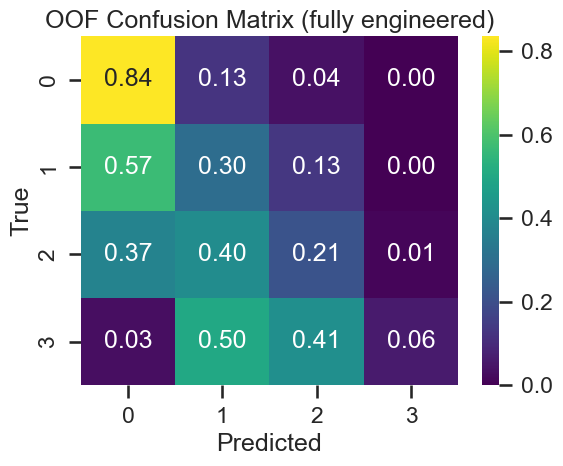

In [47]:
# ============================================================
# LightGBM on fully engineered data
# ============================================================

lgb_params = dict(
    objective="multiclass",
    num_class=n_classes,
    n_estimators=600,      # slightly stronger than raw baseline
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

lgb_results_final = train_cv_model(
    model_name="LGBM",
    base_model_cls=LGBMClassifier,
    base_params=lgb_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=lgb_results_final["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)



Training XGB [final]
Class weights: {np.int64(0): np.float64(0.42910915934755334), np.int64(1): np.float64(0.936986301369863), np.int64(2): np.float64(1.8095238095238095), np.int64(3): np.float64(20.11764705882353)}

--- Fold 1/5 ---
Fold 1 metrics:
  QWK: 0.4068
  Accuracy: 0.5858
  MacroF1: 0.3830
  Kappa: 0.2371

--- Fold 2/5 ---
Fold 2 metrics:
  QWK: 0.4350
  Accuracy: 0.6161
  MacroF1: 0.4384
  Kappa: 0.2749

--- Fold 3/5 ---
Fold 3 metrics:
  QWK: 0.3834
  Accuracy: 0.5814
  MacroF1: 0.4120
  Kappa: 0.2238

--- Fold 4/5 ---
Fold 4 metrics:
  QWK: 0.3548
  Accuracy: 0.5905
  MacroF1: 0.3322
  Kappa: 0.2197

--- Fold 5/5 ---
Fold 5 metrics:
  QWK: 0.3619
  Accuracy: 0.5887
  MacroF1: 0.3330
  Kappa: 0.2296

CV metrics (mean ± std):
  QWK: 0.3884 ± 0.0330
  Accuracy: 0.5925 ± 0.0136
  MacroF1: 0.3797 ± 0.0473
  Kappa: 0.2370 ± 0.0222


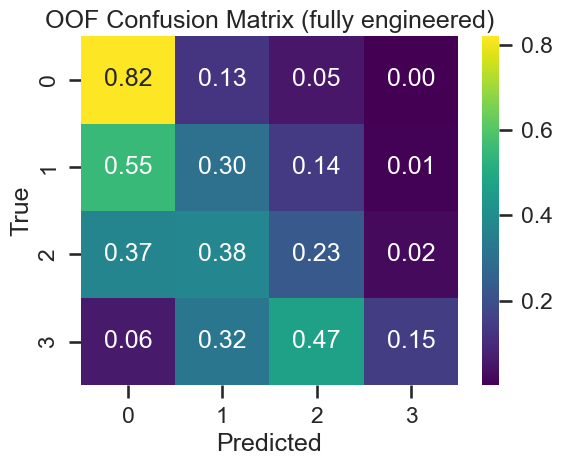

In [48]:
# ============================================================
# XGBoost on fully engineered data
# ============================================================

xgb_params = dict(
    objective="multi:softprob",
    num_class=n_classes,
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_results_final = train_cv_model(
    model_name="XGB",
    base_model_cls=XGBClassifier,
    base_params=xgb_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=xgb_results_final["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)



Training CatBoost [final]
Class weights: {np.int64(0): np.float64(0.42910915934755334), np.int64(1): np.float64(0.936986301369863), np.int64(2): np.float64(1.8095238095238095), np.int64(3): np.float64(20.11764705882353)}

--- Fold 1/5 ---
Fold 1 metrics:
  QWK: 0.4295
  Accuracy: 0.5474
  MacroF1: 0.4364
  Kappa: 0.2466

--- Fold 2/5 ---
Fold 2 metrics:
  QWK: 0.4890
  Accuracy: 0.6033
  MacroF1: 0.4508
  Kappa: 0.3045

--- Fold 3/5 ---
Fold 3 metrics:
  QWK: 0.4051
  Accuracy: 0.5503
  MacroF1: 0.4394
  Kappa: 0.2605

--- Fold 4/5 ---
Fold 4 metrics:
  QWK: 0.3896
  Accuracy: 0.5448
  MacroF1: 0.4192
  Kappa: 0.2499

--- Fold 5/5 ---
Fold 5 metrics:
  QWK: 0.4333
  Accuracy: 0.5612
  MacroF1: 0.4024
  Kappa: 0.2425

CV metrics (mean ± std):
  QWK: 0.4293 ± 0.0379
  Accuracy: 0.5614 ± 0.0242
  MacroF1: 0.4296 ± 0.0190
  Kappa: 0.2608 ± 0.0253


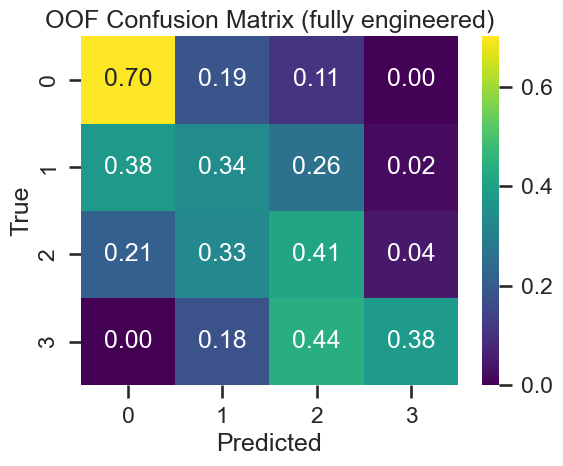

In [49]:
# ============================================================
# CatBoost on fully engineered data
# ============================================================

cat_params = dict(
    loss_function="MultiClass",
    eval_metric="TotalF1:average=Macro",
    depth=6,
    learning_rate=0.03,
    n_estimators=800,
    random_state=RANDOM_STATE,
    thread_count=-1,
    verbose=False
)

cat_results_final = train_cv_model(
    model_name="CatBoost",
    base_model_cls=CatBoostClassifier,
    base_params=cat_params,
    X=X,
    y=y,
    X_test=X_test,
    n_splits=N_SPLITS,
    random_state=RANDOM_STATE
)

plot_confusion_matrix(
    y_true=y,
    oof_pred_proba=cat_results_final["oof_pred_proba"],
    class_names=class_names,
    normalize=True
)


In [50]:
# ============================================================
# Save OOF & test predictions (fully engineered)
# ============================================================

def save_preds(results, model_key):
    oof_df = pd.DataFrame(
        results["oof_pred_proba"],
        columns=[f"proba_{cls}" for cls in class_names]
    )
    oof_df[target_col] = y_raw.values
    if id_cols:
        oof_df[id_cols[0]] = train[id_cols[0]].values
    
    oof_path = OUTPUT_DIR / f"oof_{DATA_VERSION}_{model_key}.csv"
    oof_df.to_csv(oof_path, index=False)
    
    test_df = pd.DataFrame(
        results["test_pred_proba"],
        columns=[f"proba_{cls}" for cls in class_names]
    )
    if id_cols:
        test_df[id_cols[0]] = test[id_cols[0]].values
    
    test_path = OUTPUT_DIR / f"test_{DATA_VERSION}_{model_key}.csv"
    test_df.to_csv(test_path, index=False)
    
    print(f"Saved: {oof_path}")
    print(f"Saved: {test_path}")
    

save_preds(lgb_results_final, "lgbm")
save_preds(xgb_results_final, "xgb")
save_preds(cat_results_final, "cat")


Saved: oof_predictions\oof_final_lgbm.csv
Saved: oof_predictions\test_final_lgbm.csv
Saved: oof_predictions\oof_final_xgb.csv
Saved: oof_predictions\test_final_xgb.csv
Saved: oof_predictions\oof_final_cat.csv
Saved: oof_predictions\test_final_cat.csv


In [51]:
# ============================================================
# Fully engineered summary table (per model)
# ============================================================

def summarize_model_results(model_name, res):
    mean = res["cv_mean"]
    std = res["cv_std"]
    
    # Simple LB estimate: slightly pessimistic vs CV (can be adjusted)
    lb_estimate = mean["QWK"] - 0.01
    
    return {
        "Data Version": "Fully engineered",
        "Model": model_name,
        "CV QWK (mean)": mean["QWK"],
        "CV QWK (std)": std["QWK"],
        "Accuracy": mean["Accuracy"],
        "Macro F1": mean["MacroF1"],
        "Kappa": mean["Kappa"],
        "Best Single Fold": res["best_fold_qwk"],
        "LB Estimate": lb_estimate
    }

rows_final = []
rows_final.append(summarize_model_results("LGBM", lgb_results_final))
rows_final.append(summarize_model_results("XGB", xgb_results_final))
rows_final.append(summarize_model_results("CatBoost", cat_results_final))

final_summary_df = pd.DataFrame(rows_final)
display(final_summary_df)

final_summary_path = OUTPUT_DIR / "summary_fully_engineered.csv"
final_summary_df.to_csv(final_summary_path, index=False)
print("Saved engineered summary to:", final_summary_path)


,Data Version,Model,CV QWK (mean),CV QWK (std),Accuracy,Macro F1,Kappa,Best Single Fold,LB Estimate
0,Fully engineered,LGBM,0.391750,0.034172,0.596128,0.362858,0.234668,0.427236,0.381750
1,Fully engineered,XGB,0.388370,0.033014,0.592473,0.379709,0.237012,0.434966,0.378370
2,Fully engineered,CatBoost,0.429306,0.037906,0.561409,0.429638,0.260825,0.489030,0.419306


Saved engineered summary to: oof_predictions\summary_fully_engineered.csv


In [52]:
# ============================================================
# Final comparison table: Raw vs Fully Engineered
# ============================================================

raw_summary_path = OUTPUT_DIR / "summary_raw_processed.csv"

if raw_summary_path.exists():
    raw_summary_df = pd.read_csv(raw_summary_path)
    print("Loaded raw summary from:", raw_summary_path)
else:
    print("WARNING: Raw summary file not found. "
          "Please run 2_Baseline_Comparison.ipynb first.")
    # We'll create an empty placeholder
    raw_summary_df = pd.DataFrame(
        columns=[
            "Data Version", "Model", "CV QWK (mean)", "CV QWK (std)",
            "Accuracy", "Macro F1", "Kappa", "Best Single Fold", "LB Estimate"
        ]
    )

# Combine
comparison_df = pd.concat(
    [raw_summary_df, final_summary_df],
    axis=0,
    ignore_index=True
)

# Clean up column order and format QWK ± std string
comparison_df["CV QWK (mean ± std)"] = comparison_df.apply(
    lambda row: f"{row['CV QWK (mean)']:.3f} ± {row['CV QWK (std)']:.3f}"
    if not pd.isna(row["CV QWK (mean)"])
    else "",
    axis=1
)

final_cols = [
    "Data Version",
    "Model",
    "CV QWK (mean ± std)",
    "Accuracy",
    "Best Single Fold",
    "LB Estimate"
]

# Separate view matching the table in the prompt
final_table = comparison_df[final_cols].copy()

display(final_table.style.format({
    "Accuracy": "{:.3f}",
    "Best Single Fold": "{:.3f}",
    "LB Estimate": "{:.3f}"
}))


Loaded raw summary from: oof_predictions\summary_raw_processed.csv


,Data Version,Model,CV QWK (mean ± std),Accuracy,Best Single Fold,LB Estimate
0,Raw processed,LGBM,0.340 ± 0.039,0.567,0.388,nan
1,Raw processed,XGB,0.375 ± 0.047,0.580,0.412,nan
2,Raw processed,CatBoost,0.416 ± 0.041,0.554,0.465,nan
3,Fully engineered,LGBM,0.392 ± 0.034,0.596,0.427,0.382
4,Fully engineered,XGB,0.388 ± 0.033,0.592,0.435,0.378
5,Fully engineered,CatBoost,0.429 ± 0.038,0.561,0.489,0.419


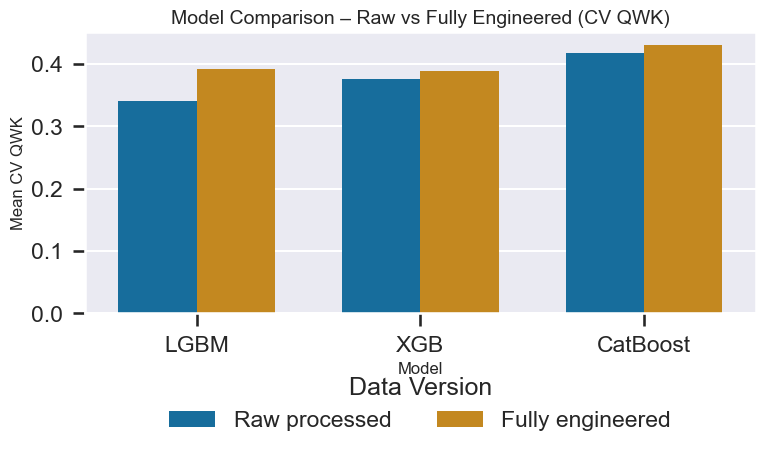

In [53]:
# ============================================================
# Visual comparison: CV QWK – Raw vs Fully Engineered
# ============================================================

# Clean data (only rows with QWK available)
plot_df = comparison_df.dropna(subset=["CV QWK (mean)"]).copy()

# Logical ordering
plot_df["Data Version"] = pd.Categorical(
    plot_df["Data Version"],
    categories=["Raw processed", "Fully engineered"],
    ordered=True
)

plot_df["Model"] = pd.Categorical(
    plot_df["Model"],
    categories=["LGBM", "XGB", "CatBoost"],
    ordered=True
)

plt.figure(figsize=(8, 5))
sns.set_palette("colorblind")

ax = sns.barplot(
    data=plot_df,
    x="Model",
    y="CV QWK (mean)",
    hue="Data Version",
    errorbar="sd",
    width=0.7
)

# Labels & Title
ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Mean CV QWK", fontsize=12)
ax.set_title("Model Comparison – Raw vs Fully Engineered (CV QWK)", fontsize=14)

# Legend BELOW the chart for clean comparison
ax.legend(
    title="Data Version",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)

# Tighter, cleaner layout
plt.tight_layout()
plt.show()


In [54]:
# ============================================================
# Key Takeaways (auto-derived + narrative)
# ============================================================

# Identify best raw and best engineered model by QWK
raw_rows = comparison_df[comparison_df["Data Version"] == "Raw processed"].copy()
final_rows = comparison_df[comparison_df["Data Version"] == "Fully engineered"].copy()

# Drop rows where QWK mean is NaN (just in case)
raw_rows = raw_rows.dropna(subset=["CV QWK (mean)"])
final_rows = final_rows.dropna(subset=["CV QWK (mean)"])

if not raw_rows.empty and not final_rows.empty:
    # idxmax returns a *label* → use .loc, not .iloc
    raw_idx = raw_rows["CV QWK (mean)"].idxmax()
    final_idx = final_rows["CV QWK (mean)"].idxmax()
    
    best_raw = raw_rows.loc[raw_idx]
    best_final = final_rows.loc[final_idx]
    
    qwk_raw = best_raw["CV QWK (mean)"]
    qwk_final = best_final["CV QWK (mean)"]
    
    relative_gain = (qwk_final - qwk_raw) / max(qwk_raw, 1e-6)
    
    print("Best RAW model:", best_raw["Model"], f"QWK={qwk_raw:.4f}")
    print("Best ENGINEERED model:", best_final["Model"], f"QWK={qwk_final:.4f}")
    print(f"Relative gain: {relative_gain*100:.1f}%")
    
    print("\nSuggested bullet points (you can copy to your report):")
    print(
        f"- Feature engineering lifts QWK from ~{qwk_raw:.2f} "
        f"to ~{qwk_final:.2f} "
        f"({relative_gain*100:.1f}% relative gain)."
    )
    print(
        f"- The model that benefits most from feature engineering "
        f"in this setup is **{best_final['Model']}**, "
        f"which achieves CV QWK ≈ {qwk_final:.3f}."
    )
else:
    print(
        "Key takeaway auto-text skipped because raw or final "
        "summary is missing or has no valid QWK values."
    )


Best RAW model: CatBoost QWK=0.4163
Best ENGINEERED model: CatBoost QWK=0.4293
Relative gain: 3.1%

Suggested bullet points (you can copy to your report):
- Feature engineering lifts QWK from ~0.42 to ~0.43 (3.1% relative gain).
- The model that benefits most from feature engineering in this setup is **CatBoost**, which achieves CV QWK ≈ 0.429.
